## Chargements des données

In [1]:
import pandas
import numpy as np

In [2]:
def open_otto_csv(file):
    return pandas.read_csv(file, sep=',')

In [3]:
files = {"train": "./res/train.csv", "test": "./res/test.csv"}
files["train"] = open_otto_csv(files["train"])
files["test"] = open_otto_csv(files["test"])

In [4]:
def get_x_y(pandas_data_frame):
    y = pandas_data_frame["target"]
    x = pandas_data_frame.drop(columns=["id", "target"])
    return x, y

In [5]:
train_x, train_y = get_x_y(files["train"])

## Quelques observations sur les données

In [6]:
train_x.info(max_cols=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61878 entries, 0 to 61877
Columns: 93 entries, feat_1 to feat_93
dtypes: int64(93)
memory usage: 43.9 MB


In [7]:
nbre_example = len(train_x)
class_list = set(train_y)
nbre_class = len(class_list)
print("le nombre d'exemples dans le dataset est de :", nbre_example)
print("le nombre de classes différentes est de :", nbre_class)
print(class_list)

le nombre d'exemples dans le dataset est de : 61878
le nombre de classes différentes est de : 9
{'Class_7', 'Class_2', 'Class_9', 'Class_6', 'Class_4', 'Class_3', 'Class_5', 'Class_1', 'Class_8'}


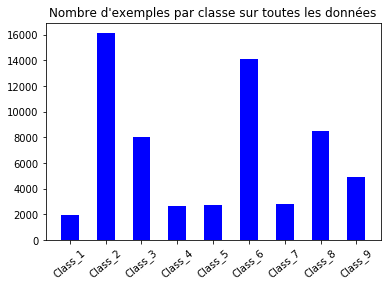

In [8]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pylab

def mk_dict_labels(all_y):
    values = []
    count_labels = {}
    for row in all_y.values:
        values.append(row)
    for l in values:
        if l in count_labels:
            count_labels[l] += 1
        else:
            count_labels[l] = 1
    return count_labels

def plot_hist(labels, data):
    labels = [(k,v) for k, v in labels.items()]
    labels.sort(key=lambda k: k[0])
    x = [i for i in range(len(labels))]
    x_name = [k for k,_ in labels]
    y = [v for _,v in labels]
    if data == "all_data":
        plt.title("Nombre d'exemples par classe sur toutes les données")
        colorBar = "blue"
    if data == "train_data":
        plt.title("Nombre d'exemples par classe sur les données d'entrainement")
        colorBar = "green"
    if data == "valid_data":
        plt.title("Nombre d'exemples par classe sur les données de validation")
        colorBar = "purple"
    plt.bar(x, y, 0.5, color=colorBar)
    pylab.xticks(x, x_name, rotation=40)
    plt.show()
    
count_labels = mk_dict_labels(train_y)
plot_hist(count_labels, "all_data")    

## Division des données en apprentissage/validation

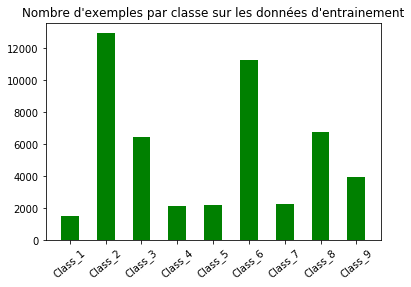

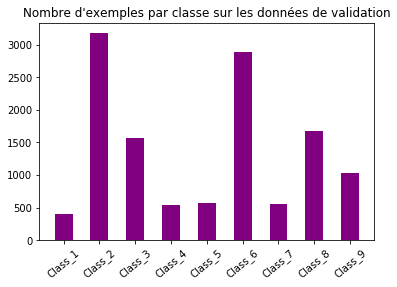

12376


In [9]:
from sklearn.model_selection import train_test_split

# Split des données en partition de train et partition de validation
# 80% -> train
# 20% -> validation
data_train, data_valid, labels_train, labels_valid = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# Nombre d'exemples par classe pour les données d'entrainement
count_labels_t = mk_dict_labels(labels_train)
plot_hist(count_labels_t, "train_data")

# Nombre d'exemples par classe pour les données de validation
count_labels_v = mk_dict_labels(labels_valid)
plot_hist(count_labels_v, "valid_data")

print(len(data_valid))

<strong>Remarque</strong> : On observe que la distribution au niveau du nombre d'exemples en fonction des classes est préservée même après le split.

In [10]:
from sklearn.metrics import f1_score

def evaluate_model(true_y, y_pred):
    score = f1_score(true_y, y_pred, average = 'weighted')
    tmp_y=np.asarray(true_y)
    print("f1_score precision : (version sklearn)", score)
    print("evaluation (version Sam) : ")
    print(tmp_y[tmp_y==y_pred].shape[0], "/", y_pred.shape[0])
    print("Precision : %f" % (tmp_y[tmp_y==y_pred].shape[0] / y_pred.shape[0]))
    

## Création du fichier csv pour la soumission Kaggle

In [23]:
testx = files["test"].drop(columns=["id"])

def make_csv_soumission(model, test_x, fileName, nb_class):
    y = model.predict_proba(test_x)
    dt = pandas.DataFrame(data=y, \
                          index=np.arange(1, y.shape[0]+1), \
                          columns=["Class_1","Class_2","Class_3","Class_4", \
                                   "Class_5","Class_6","Class_7","Class_8","Class_9"])
    dt.to_csv(fileName, sep=",", index_label="id")

## Comparatif sur quelques classifiers différents

### Classifier : SVM

In [12]:
import sklearn.svm as svm

In [33]:
svc = svm.SVC(max_iter = 1000, gamma='auto', probability=True)
svc.fit(train_x, train_y)

#y_pred2 = svc.predict(data_valid)

#evaluate_model(labels_valid, y_pred2)

/home/samuel/env/lib/python3.5/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=1000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [34]:
make_csv_soumission(svc, testx, "res_svm.csv", nbre_class) # 0.75649

### Classifier : K-NN

In [56]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(data_train, labels_train)

y_pred3 = knn.predict(data_valid)

evaluate_model(labels_valid, y_pred3)

f1_score precision : (version sklearn) 0.7739562191425366
evaluation (version Sam) : 
9662 / 12376
Precision : 0.780705


In [58]:
make_csv_soumission(knn, testx, "res_knn.csv", nbre_class)

### Classifier : Naive Bayes

In [59]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(data_train, labels_train)

y_pred4 = nb.predict(data_valid)

evaluate_model(labels_valid, y_pred4)

f1_score precision : (version sklearn) 0.6286302230265768
evaluation (version Sam) : 
7684 / 12376
Precision : 0.620879


In [60]:
make_csv_soumission(knn, testx, "res_GaussNaiveBayes.csv", nbre_class)

### Classifier : Perceptron

In [64]:
from sklearn.linear_model import Perceptron

perceptron_clf = Perceptron(max_iter = 1000)
perceptron_clf.fit(data_train, labels_train)

y_pred5 = perceptron_clf.predict(data_valid)

evaluate_model(labels_valid, y_pred5)

f1_score precision : (version sklearn) 0.690788007968747
evaluation (version Sam) : 
8718 / 12376
Precision : 0.704428


### Classifier : Regression Logistique

In [65]:
from sklearn.linear_model import LogisticRegression

logistic_clf = LogisticRegression(max_iter = 1000)
logistic_clf.fit(data_train, labels_train)

y_pred6 = logistic_clf.predict(data_valid)

evaluate_model(labels_valid, y_pred6)

f1_score precision : (version sklearn) 0.7343083104433648
evaluation (version Sam) : 
9367 / 12376
Precision : 0.756868


### Classifier : SGDClassifier = modèle linéaire + descente de gradient stochastique

In [25]:
from sklearn.linear_model import SGDClassifier

In [27]:
SGD_clf = SGDClassifier(max_iter=1000)
SGD_clf.fit(train_x, train_y)

#y_pred7 = SGD_clf.predict(data_valid)

#evaluate_model(labels_valid, y_pred7)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

## Optimisation d'hyper-paramètres sur certains classifier

In [12]:
# On fait un split servant uniquement à réduire le nombre d'exemples du train car l'étape de recherche des meilleurs
# hyper-paramètres est très couteuse.
test_tx, test_vx, test_ty, test_vy = train_test_split(train_x, train_y, test_size=0.9, random_state=42)

print(len(test_tx))

6187


### Recherche des meilleurs paramètres pour KNN

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [42]:
paramsKNN = {'n_neighbors' : [4,5,6],
             'weights'     : ['uniform', 'distance'],
             'algorithm'   : ['ball_tree', 'kd_tree', 'brute', 'auto'],
             'leaf_size'   : [20, 30],
             'p'           : [1,2]}

knn = GridSearchCV(KNeighborsClassifier(), param_grid = paramsKNN)
knn.fit(test_tx, test_ty)

print(knn.best_params_)

6187
{'algorithm': 'ball_tree', 'leaf_size': 20, 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}


In [15]:
knnOptim = KNeighborsClassifier(n_neighbors = 6, weights = 'distance', algorithm = 'brute', leaf_size = 20, p = 2)
knnOptim.fit(data_train, labels_train)

y_predOptim = knnOptim.predict(data_valid)

evaluate_model(labels_valid, y_predOptim)

f1_score precision : (version sklearn) 0.7859400968452307
evaluation (version Sam) : 
9786 / 12376
Precision : 0.790724


In [24]:
make_csv_soumission(knnOptim, testx, "res_knn_opti.csv", nbre_class)

### Recherche des meilleurs paramètres pour SVM SVC

In [60]:
from sklearn.model_selection import GridSearchCV

paramsSVC = {'C'      : [1,10,100,1000],
             'kernel' : ['rbf', 'linear', 'poly', 'sigmoid'],
             'gamma'  : [1e-3, 1e-4],
             'tol'    : [1e-3, 1e-4]}

svc = GridSearchCV(svm.SVC(max_iter = 1000), param_grid = paramsSVC)
svc.fit(test_tx, test_ty)

print(svc.best_params_)

/home/biard/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/biard/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/biard/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/biard/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/biard/

/home/biard/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/biard/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/biard/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/biard/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/biard/

/home/biard/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/biard/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/biard/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/biard/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/biard/

/home/biard/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/biard/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/biard/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/biard/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/biard/

/home/biard/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/biard/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/biard/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/biard/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/biard/

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf', 'tol': 0.001}


/home/biard/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [62]:
svc = svm.SVC(max_iter = 1000, C = 10, gamma = 0.001, kernel = 'rbf', tol = 0.001)
svc.fit(data_train, labels_train)

y_predOptimSVC = svc.predict(data_valid)

evaluate_model(labels_valid, y_predOptimSVC)

## MDR c'est trop nul

/home/biard/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


f1_score precision : (version sklearn) 0.6107105352232192
evaluation (version Sam) : 
7567 / 12376
Precision : 0.611425
